### Basic Idea

1. Cut the image up
2. Put it through a VAE
3. Then:
    1. The whole image is the _real_ image
    2. The generated image is the _fake_ image
4. GAN tells you which one is the real one

In [2]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import Compose, Normalize, ToTensor, ToPILImage, RandomCrop
from torch import Tensor
import time

import os
import random

from PIL import Image

from torch.types import *
from typing import Optional, Callable

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [4]:
# Hyper Parameters:
hidden_size = 256
lstm_hidden_size = 8
num_epochs = 2000
batch_size = 64
lr = 0.00005
weight_decay = 0.00002
clip_value = 0.1

input_size = 128
lstm_input_size = 4
input_height = 128
lstm_input_height = 1024
sequence_length = 4
num_layers = 2

In [5]:
# starting out with building and visualizing data to understand it
class SceneryDataset(Dataset):
    def __init__(self, data_folder, test=False):
        self.data_folder = data_folder

        if not os.path.isdir(data_folder):
            raise FileNotFoundError(f"Could not find files in {data_folder}")
        
        self.images = [*map(lambda file: os.path.join(data_folder, file), os.listdir(data_folder))]

        random.shuffle(self.images)

    def transform(self, image):
        w, h = image.size
        return ToTensor()(image.crop((0, 0, w // 2, h)))

    def __getitem__(self, i):
        image = Image.open(self.images[i]).convert('RGB')

        # main data/label = full image, resized
        image = image.resize((hidden_size, input_height), Image.BILINEAR)

        return (self.transform(image), ToTensor()(image))

    def __len__(self):
        return len(self.images)


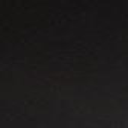

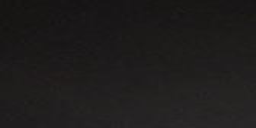

In [6]:
# testing the dataset
dataFolder = './dataset/train/data'

scenery = SceneryDataset(dataFolder)

(image, label) = scenery[0]
image = ToPILImage()(image)

label = ToPILImage()(label)
display(image)
display(label)

In [7]:
# class MaskedMSELoss(nn.Module):
#     def __init__(self):
#         super(MaskedMSELoss, self).__init__()

#     def forward(self, input, target, mask):
#         diff2 = (torch.flatten(input) - torch.flatten(target)) ** 2.0
#         sum2 = 0.0
#         num = 0

#         flat_mask = torch.flatten(mask)
#         assert(len(flat_mask) == len(diff2))
#         for i in range(len(diff2)):
#             if flat_mask[i] == 1:
#                 sum2 += diff2[i]
#                 num += 1

#         return sum2 / num

criterion = nn.MSELoss()

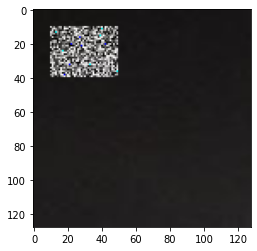

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# testing loss
def add_random_noise(imageTensor):
    w, h = 30, 40
    copyTensor = imageTensor.detach().clone()
    copyTensor[:, 10:10+w, 10:10+h] += ((255 * torch.rand((w, h))) % 255)
    return copyTensor

sample = scenery[0]
# plt.imshow(ToPILImage()(sample * 255.0))

sample_noisy = add_random_noise(sample[0])
plt.imshow(ToPILImage()(sample_noisy))


In [9]:
criterion(sample_noisy, sample[0])

tensor(1586.0983)

## Making the Model

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, padding=0, resize=None):
        super(ConvBlock, self).__init__()
        self.cnn = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation, padding=padding)
        self.norm = nn.InstanceNorm2d(out_channels)
        self.act = (
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.resize = resize

    def forward(self, x):
        out = self.act(self.norm(self.cnn(x)))
        if self.resize:
            out.reshape(-1, *self.resize)
        return out

In [11]:
class TransConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=2, dilation=1, padding=0, output_padding=0):
        super(TransConvBlock, self).__init__()
        self.cnn = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation, output_padding=output_padding, padding=padding)
        self.norm = nn.InstanceNorm2d(out_channels)
        self.act = (
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.act(self.norm(self.cnn(x)))

In [12]:
# Recurrent Content Transfer
# currently it is a simple LSTM for understanding purposes
class RCTBlock(nn.Module):
    # def __init__(self, in_channels, out_channels, kernel_size, hidden_size, num_layers=2):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RCTBlock, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Blocks
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x: Tensor):
        # initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # resizing the tensor
        # x = x.reshape(-1, 4, 4*self.input_size)

        out, _ = self.lstm(x, (h0, c0)) 

        return out       

In [13]:
class CustomResBlock(nn.Module):
    def __init__(self, in_channels, out_channels: List[int], downscale=ConvBlock, padding=[0, 1, 0], stride=2):
        super(CustomResBlock, self).__init__()

        conv1_out, conv2_out, conv3_out = out_channels
        pad1, pad2, pad3 = padding
        self.conv1 = ConvBlock(in_channels, conv1_out, 1, padding=pad1)

        self.conv2 = ConvBlock(conv1_out, conv2_out, 3, stride=stride, padding=pad2)

        self.conv3 = ConvBlock(conv2_out, conv3_out, 1, padding=pad3)

        if downscale is None:
            self.shortcut = None
        else:
            self.shortcut = downscale(in_channels, conv3_out, 1, stride=2)

    def forward(self, x: Tensor) -> Tensor:
        identity = x.clone()

        out: Tensor = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        if self.shortcut is not None:
            out = out + self.shortcut(identity)
        else:
            # print(out.shape, identity.shape)
            out = out + identity

        return out

In [14]:
class GRB(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=2):
        super(GRB, self).__init__()

        self.conv11 = ConvBlock(in_channels, out_channels, (3, 1), padding=1, dilation=dilation)

        self.conv12 = ConvBlock(out_channels, out_channels // 2, (1, 7), padding=1, dilation=dilation)

        self.conv21 = ConvBlock(out_channels, out_channels, (1, 7), padding=1, dilation=dilation)

        self.conv22 = ConvBlock(out_channels, out_channels, (3, 1), padding=1, dilation=dilation)

    def forward(self, x: Tensor) -> Tensor:
        short0 = x.clone()

        out = self.conv11(x)
        out = self.conv12(out)
        short1 = out.clone()

        out = self.conv21(x)
        out = self.conv22(out)

        return out + short0 + short1

In [15]:
class SHC(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes, dilation=1, stride=1):
        super(SHC, self).__init__()

        k1, k2, k3 = kernel_sizes

        self.conv1 = ConvBlock(in_channels, out_channels // 2, k1, dilation=dilation)

        self.conv2 = ConvBlock(out_channels // 2, out_channels // 2, k2, dilation=dilation)

        self.conv3 = ConvBlock(out_channels // 2, out_channels, k3, dilation=dilation, stride=stride)

    def forward(self, x: Tensor, shortcut: Tensor) -> Tensor:
        # print(x.shape)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        out = out + shortcut

        # out = torch.cat([out1, other], dim=3)
        return out

In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = ConvBlock(3, 64, 4, stride=2, padding=1)
        self.conv2 = ConvBlock(64, 128, 4, stride=2, padding=1)

        self.enres1 = nn.Sequential(
            CustomResBlock(128, [64, 64, 256]),
            CustomResBlock(256, [64, 64, 256], downscale=None, stride=1)
        )

        self.enres2 = nn.Sequential(
            CustomResBlock(256, [128, 128, 512]),
            CustomResBlock(512, [128, 128, 512], downscale=None, stride=1),
            CustomResBlock(512, [128, 128, 512], downscale=None, stride=1),
        )

        self.enres3 = nn.Sequential(
            CustomResBlock(512, [256, 256, 1024]),
            CustomResBlock(1024, [256, 256, 1024], downscale=None, stride=1),
            CustomResBlock(1024, [256, 256, 1024], downscale=None, stride=1),
        )

        # self.extend = ConvLSTM(4, 8, (1, 1), 2, batch_first=True)
        self.extend = RCTBlock(4, 8, 4)

        self.decres1 = nn.Sequential(
            CustomResBlock(1024, [256, 256, 1024], downscale=None, stride=1),
            TransConvBlock(1024, 512, 4, stride=2, padding=1),
        )

        self.shcm3 = SHC(512, 512, kernel_sizes=[(1, 3), (1, 5), (1, 3)])

        self.decres2 = nn.Sequential(
            CustomResBlock(512, [128, 128, 512],downscale=None, stride=1),
            TransConvBlock(512, 256, 4, stride=2, padding=1),
        )

        self.decres3 = nn.Sequential(
            CustomResBlock(256, [64, 64, 256], downscale=None, stride=1),
            TransConvBlock(256, 128, 4, stride=2, padding=1),
        )

        self.transconvm2 = TransConvBlock(128, 64, 4, stride=2, padding=1)

        self.transconvm1 = TransConvBlock(64, 3, 4, stride=2, padding=1)

    def forward(self, x: Tensor):
        encoded: Tensor = self.conv1(x)
        encoded = self.conv2(encoded)

        encoded = self.enres1(encoded)
        encoded = self.enres2(encoded)
        short_cut = encoded.clone()
        encoded = self.enres3(encoded)

        encoded = encoded.reshape(-1, 4096, 4)
        extended: Tensor = self.extend(encoded)
        extended = extended.reshape(-1, 1024, 4, 8)

        decoded = self.decres1(extended)
        
        sc, kp = torch.split(decoded, split_size_or_sections=8, dim=3)
        merge = torch.cat([short_cut, sc], dim=3)
        merge = self.shcm3(merge, short_cut)
        decoded = torch.cat([merge, kp], dim=3)

        decoded = self.decres2(decoded)
        decoded = self.decres3(decoded)
        decoded = self.transconvm2(decoded)

        decoded = self.transconvm1(decoded)

        return decoded

In [17]:
generator = Model().to(device)
optimizer = torch.optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay)

In [18]:
from torch.utils.data import DataLoader

train_loader = DataLoader(scenery, batch_size, shuffle=True)

[i.shape for i in next(iter(train_loader))]

[torch.Size([64, 3, 128, 128]), torch.Size([64, 3, 128, 256])]

In [55]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # only needed for the initial lstm
        images = images.to(device)
        labels = labels.to(device)

        outputs = generator(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(generator.parameters(), clip_value)
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    if epoch % 20 == 0:
        torch.save(generator.state_dict(), f'saved/{round(time.time())}-epoch-{epoch}-generator.pth')

print("Done :)")
        

KeyboardInterrupt: 

In [71]:
torch.save(generator.state_dict(), f'saved/{round(time.time())}-epoch-{epoch}-generator.pth')

In [19]:
generator = Model().to(device)
generator.load_state_dict(torch.load('saved\\<model-name>'))

<All keys matched successfully>

In [20]:
test_dataset = SceneryDataset('./dataset/test/data', test=True)
test_loader = DataLoader(scenery, batch_size, shuffle=True) 

## Visual Testing

0.15020553767681122


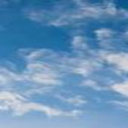

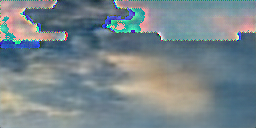

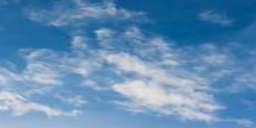

In [24]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0

    for images, labels in test_loader:
        # images = images.reshape(-1, sequence_length, input_size).to(device)
        images = images.to(device)
        labels = labels.to(device)

        outputs = generator(images)

        loss = criterion(outputs, labels)
        # outputs = outputs.reshape(-1, 3, input_height, hidden_size)

        print(loss.item())
        display(ToPILImage('RGB')(images[0]))
        display(ToPILImage('RGB')(outputs[0]))
        display(ToPILImage('RGB')(labels[0]))

        break